<a href="https://colab.research.google.com/github/Intina47/DEEP_LEARNING/blob/main/malaria/malaria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

DATA PREPARATION

In [22]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split=['train'])

In [ ]:
for data in dataset[0].take(1):
  print(data)

DATA CLASIFICATION -specify VALIDATION AND TESTING DATA

In [23]:
def split(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)
  training_dataset = dataset.take(int(DATASET_SIZE*TRAIN_RATIO)) #take 60% of the whole dataset to be training data
  val_test_dataset = dataset.skip((int(DATASET_SIZE*TRAIN_RATIO)))#skip the first 60% of the dataset
  valiadation_dataset = val_test_dataset.take(int(DATASET_SIZE*VAL_RATIO)) #take 20% of val_test_dataset
  test_dataset = val_test_dataset.skip(int(DATASET_SIZE*VAL_RATIO)) #take 20% the remaining dataset

  return training_dataset,valiadation_dataset,test_dataset

In [35]:
TRAIN_RATIO = 0.6
VAL_RATIO = 0.2
TEST_RATIO = 0.2

training_dataset,valiadation_dataset,test_dataset = split(dataset[0],TRAIN_RATIO, VAL_RATIO,TEST_RATIO)
# print(list(training_dataset.take(1).as_numpy_iterator()))
# print(list(valiadation_dataset.take(1).as_numpy_iterator()))
# print(list(test_dataset.take(1).as_numpy_iterator()))

DATA VISUALIZATION


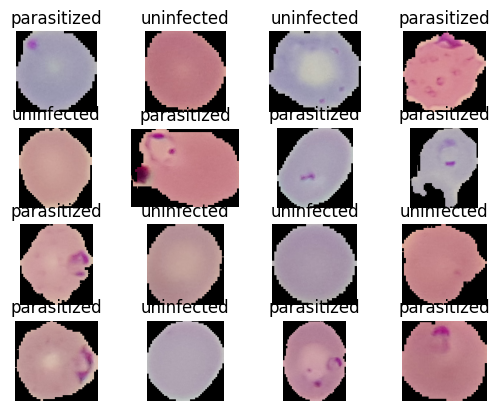

In [32]:
for i ,(image, label) in enumerate(training_dataset.take(16)):
  ax = plt.subplot(4,4,i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

In [10]:
dataset_info.features['label'].int2str(label)

'parasitized'

DATA PROCESSING

In [25]:
IMG_SIZE = 124
def img_resizing(image, label):
  return tf.image.resize(image, (IMG_SIZE,IMG_SIZE))/255.0,label

In [36]:
training_dataset = training_dataset.map(img_resizing) #speed processing
valiadation_dataset = valiadation_dataset.map(img_resizing)
test_dataset = test_dataset.map(img_resizing)

In [9]:
for image, label in valiadation_dataset.take(1):
  print('success fetching resized data!')

success fetching resized data!


In [27]:
training_dataset = training_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(20).prefetch(tf.data.AUTOTUNE)
valiadation_dataset = valiadation_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(20).prefetch(tf.data.AUTOTUNE)

MODEL

In [49]:
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape=(IMG_SIZE,IMG_SIZE,3)),
    Conv2D(filters=6, kernel_size=5, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Conv2D(filters=16, kernel_size=5, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Flatten(),

    Dense(100, activation='relu'),
    BatchNormalization(),
    Dense(10, activation='relu'),
    BatchNormalization(),
    Dense(1),
])
lenet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 120, 120, 6)       456       
                                                                 
 batch_normalization_8 (Batc  (None, 120, 120, 6)      24        
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 60, 60, 6)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 56, 16)        2416      
                                                                 
 batch_normalization_9 (Batc  (None, 56, 56, 16)       64        
 hNormalization)                                                 
                                                      

Compile model

In [50]:
lenet_model.compile(optimizer=Adam(learning_rate=1), loss=BinaryCrossentropy(), metrics='accuracy')

TRAINING MODEL

In [13]:
history = lenet_model.fit(training_dataset, validation_data=valiadation_dataset, epochs=20, verbose=1)

Epoch 1/20
827/827 [==============================] - 42s 43ms/step - loss: 7.6311 - accuracy: 0.5049 - val_loss: 7.7183 - val_accuracy: 0.4995
Epoch 2/20
827/827 [==============================] - 34s 41ms/step - loss: 7.7744 - accuracy: 0.4958 - val_loss: 7.7419 - val_accuracy: 0.4981
Epoch 3/20
827/827 [==============================] - 33s 40ms/step - loss: 7.7031 - accuracy: 0.5006 - val_loss: 7.7304 - val_accuracy: 0.4988
Epoch 4/20
827/827 [==============================] - 33s 40ms/step - loss: 7.7069 - accuracy: 0.5004 - val_loss: 7.7248 - val_accuracy: 0.4992
Epoch 5/20
827/827 [==============================] - 31s 38ms/step - loss: 7.7069 - accuracy: 0.5004 - val_loss: 7.7332 - val_accuracy: 0.4986
Epoch 6/20
827/827 [==============================] - 33s 39ms/step - loss: 7.7041 - accuracy: 0.5005 - val_loss: 7.7220 - val_accuracy: 0.4994
Epoch 7/20
827/827 [==============================] - 33s 39ms/step - loss: 7.7050 - accuracy: 0.5005 - val_loss: 7.7359 - val_accuracy:

In [45]:
history

Performance Measurement

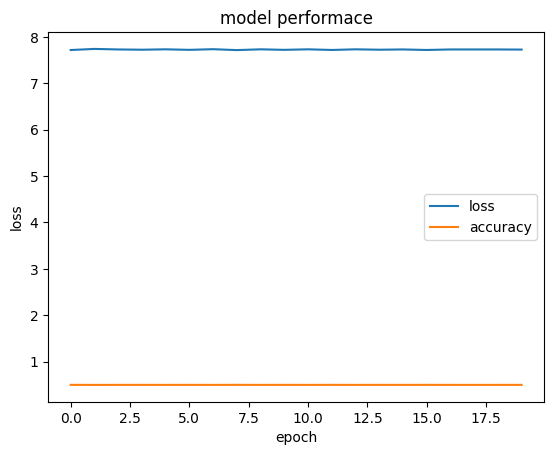

In [46]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_accuracy'])
plt.title('model performace')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'accuracy'])
plt.show()

TESTING

In [47]:
test_dataset.batch(1)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 124, 124, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [51]:
lenet_model.evaluate(test_dataset)

ValueError: ignored

In [30]:
lenet_model.predict(test_dataset.take(1))[0][0]

ValueError: ignored

In [ ]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_path='/root/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear i